# Bayesian Model Variants

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import arviz as az
import pymc as pm
import pytensor
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.calibration import calibration_curve

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

purple_color = '#5F249F'
teal_color = '#005F61'
red_color = '#A71930'

In [5]:
pitcher_data_w_injuries = pd.read_csv('pitcher_data_w_injuries.csv').iloc[:, 1:].copy()
pitcher_data_w_injuries

,player_name,pitcher,game_year,num_pitches_thrown,num_games,num_bf,bf_per_game,pitches_per_game,pitcher_role,hrel_sd,vrel_sd,BB%,FB%,OS%,BB_avg_velo,FB_avg_velo,OS_avg_velo,BB_avg_hb,FB_avg_hb,OS_avg_hb,BB_avg_ivb,FB_avg_ivb,OS_avg_ivb,BB_avg_spin,FB_avg_spin,OS_avg_spin,BB_avg_ext,FB_avg_ext,OS_avg_ext,BB_avg_spin_axis,FB_avg_spin_axis,OS_avg_spin_axis,BB_max_velo,FB_max_velo,OS_max_velo,BB_max_hb,FB_max_hb,OS_max_hb,BB_max_ivb,FB_max_ivb,OS_max_ivb,BB_max_spin,FB_max_spin,OS_max_spin,BB_max_ext,FB_max_ext,OS_max_ext,BB_max_spin_axis,FB_max_spin_axis,OS_max_spin_axis,birth_country,height,weight,hand,age,bmi,prev_arm_inj_hist,injury_next_year,had_arm_injury_this_year,Δ_num_pitches_thrown,Δ_num_games,Δ_num_bf,Δ_bf_per_game,Δ_pitches_per_game,Δ_hrel_sd,Δ_vrel_sd,Δ_BB%,Δ_FB%,Δ_OS%,Δ_BB_avg_velo,Δ_FB_avg_velo,Δ_OS_avg_velo,Δ_BB_avg_hb,Δ_FB_avg_hb,Δ_OS_avg_hb,Δ_BB_avg_ivb,Δ_FB_avg_ivb,Δ_OS_avg_ivb,Δ_BB_avg_spin,Δ_FB_avg_spin,Δ_OS_avg_spin,Δ_BB_avg_ext,Δ_FB_avg_ext,Δ_OS_avg_ext,Δ_BB_avg_spin_axis,Δ_FB_avg_spin_axis,Δ_OS_avg_spin_axis,Δ_BB_max_velo,Δ_FB_max_velo,Δ_OS_max_velo,Δ_BB_max_hb,Δ_FB_max_hb,Δ_OS_max_hb,Δ_BB_max_ivb,Δ_FB_max_ivb,Δ_OS_max_ivb,Δ_BB_max_spin,Δ_FB_max_spin,Δ_OS_max_spin,Δ_BB_max_ext,Δ_FB_max_ext,Δ_OS_max_ext,Δ_BB_max_spin_axis,Δ_FB_max_spin_axis,Δ_OS_max_spin_axis,first_year
0,a.j. alexy,669935,2021,424,5,97,19.400000,84.800000,SP,0.164822,0.105536,0.273585,0.544811,0.181604,79.511207,93.312554,85.787013,8.277931,-4.217143,-7.884156,-6.241034,19.224935,11.808312,2407.146552,2218.346320,1487.493506,6.644828,6.722078,6.683117,55.413793,199.805195,218.493506,83.8,96.5,88.4,14.64,2.40,-1.08,4.56,22.92,17.28,2623.0,2414,1872.0,7.2,7.2,7.0,95,210,229.0,USA,1.930404,88.435374,R,23,23.731744,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,1
1,a.j. alexy,669935,2022,152,4,38,9.500000,38.000000,RP,0.187445,0.124392,0.355263,0.559211,0.085526,81.942593,94.216471,88.300000,6.004444,-6.786353,-10.412308,-5.777778,18.217412,10.200000,2436.333333,2138.670588,1503.538462,6.396296,6.494118,6.476923,76.462963,203.905882,215.769231,87.5,97.7,90.5,9.96,-1.56,-6.96,5.52,21.72,15.48,2605.0,2333,1831.0,6.9,7.3,6.6,153,214,225.0,USA,1.930404,88.435374,R,24,23.731744,0.0,0.0,0.0,-272.0,-1.0,-59.0,-9.900000,-46.800000,0.022623,0.018856,0.081678,0.014399,-0.096077,2.431386,0.903916,2.512987,-2.273487,-2.569210,-2.528152,0.463257,-1.007523,-1.608312,29.186782,-79.675732,16.044955,-0.248531,-0.227960,-0.206194,21.049170,4.100688,-2.724276,3.7,1.2,2.1,-4.68,-3.96,-5.88,0.96,-1.20,-1.80,-18.0,-81,-41.0,-0.3,0.1,-0.4,58,4,-4.0,0
2,a.j. cole,595918,2018,871,32,220,6.875000,27.218750,RP,0.191610,0.159906,0.636051,0.337543,0.026406,82.808484,93.403061,86.460870,1.816462,-9.923673,-16.523478,3.728014,15.149388,8.045217,2269.363462,2168.666667,1921.565217,6.066245,6.256803,6.313043,143.115523,212.976190,243.826087,87.9,96.4,89.2,8.52,-3.00,-12.36,10.44,20.40,12.12,2557.0,2435,2029.0,6.7,7.3,6.9,223,239,253.0,USA,1.955804,108.843537,R,26,28.454570,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,1
3,a.j. cole,595918,2019,480,25,118,4.720000,19.200000,RP,0.244201,0.128350,0.531250,0.450000,0.018750,83.149412,94.361111,86.633333,2.025412,-8.407222,-16.173333,4.542118,17.083889,11.133333,2371.224900,2406.342593,2197.777778,6.245490,6.523148,6.466667,150.890196,205.986111,235.555556,87.0,97.5,89.1,9.60,-4.08,-13.08,9.36,20.64,14.40,2656.0,2752,2372.0,6.9,7.0,6.7,218,219,245.0,USA,1.955804,108.843537,R,27,28.454570,0.0,0

## Data Prep

In [6]:
pitcher_data_w_injuries = pd.read_csv('pitcher_data_w_injuries.csv').iloc[:, 1:].copy()
## doing some encoding 
pitcher_data_w_injuries['hand'] = (pitcher_data_w_injuries['hand'] == 'R').astype(int) ## encodes handedness -> R = 1, L = 0
pitcher_data_w_injuries['pitcher_role'] = (pitcher_data_w_injuries['pitcher_role'] == 'SP').astype(int) ## encodes pitcher role -> SP = 1, RP = 0
pitcher_data_w_injuries['game_year'] = pitcher_data_w_injuries['game_year'].astype('category') ## encoding season as a categorical var rather than numerical
pitcher_data_w_injuries['prev_arm_inj_hist'] = pitcher_data_w_injuries['prev_arm_inj_hist'].astype('category') ## encoding inj hist as a categorical var rather than numerical
pitcher_data_w_injuries['birth_country'] = pitcher_data_w_injuries['birth_country'].astype('category')
### saves the mappings before they're encoded
game_year_mapping = dict(enumerate(pitcher_data_w_injuries['game_year'].cat.categories))
prev_inj_mapping = dict(enumerate(pitcher_data_w_injuries['prev_arm_inj_hist'].cat.categories))
birth_country_mapping = dict(enumerate(pitcher_data_w_injuries['birth_country'].cat.categories))
### now encodes them as integer codes
pitcher_data_w_injuries['game_year'] = pitcher_data_w_injuries['game_year'].cat.codes
pitcher_data_w_injuries['birth_country'] = pitcher_data_w_injuries['birth_country'].cat.codes
pitcher_data_w_injuries['prev_arm_inj_hist'] = pitcher_data_w_injuries['prev_arm_inj_hist'].cat.codes

## to make MCMC sampling stable and interpretable, we'll standardize continuous variables (also keeps from certain predictors being emphasized, e.g., spin rate)
## we'll standardize using the values from our training set ONLY --> we'll risk leaking data if we use 2024-2025 data
pitcher_data_w_injuries_train = pitcher_data_w_injuries[pitcher_data_w_injuries['game_year'].isin([0, 1, 2, 3, 4, 5])] ## training = 2018-2023
pitcher_data_w_injuries_test = pitcher_data_w_injuries[pitcher_data_w_injuries['game_year'] == 6] ## held-out test = 2024
pitcher_data_w_injuries_forecast = pitcher_data_w_injuries[pitcher_data_w_injuries['game_year'] == 7] ## the dataset we want to forecast = 2025 (for 2026)

train_dict = {'age': {'mu': pitcher_data_w_injuries_train['age'].mean(), 'sigma': pitcher_data_w_injuries_train['age'].std()},
              'bmi': {'mu': pitcher_data_w_injuries_train['bmi'].mean(), 'sigma': pitcher_data_w_injuries_train['bmi'].std()},
              'height': {'mu': pitcher_data_w_injuries_train['height'].mean(), 'sigma': pitcher_data_w_injuries_train['height'].std()},
              'FB%': {'mu': pitcher_data_w_injuries_train['FB%'].mean(), 'sigma': pitcher_data_w_injuries_train['FB%'].std()},
              'FB_avg_spin': {'mu': pitcher_data_w_injuries_train['FB_avg_spin'].mean(), 'sigma': pitcher_data_w_injuries_train['FB_avg_spin'].std()},
              'FB_max_ivb': {'mu': pitcher_data_w_injuries_train['FB_max_ivb'].mean(), 'sigma': pitcher_data_w_injuries_train['FB_max_ivb'].std()},
              'FB_max_spin': {'mu': pitcher_data_w_injuries_train['FB_max_spin'].mean(), 'sigma': pitcher_data_w_injuries_train['FB_max_spin'].std()},
              'FB_max_velo': {'mu': pitcher_data_w_injuries_train['FB_max_velo'].mean(), 'sigma': pitcher_data_w_injuries_train['FB_max_velo'].std()},
              'Δ_FB_avg_hb': {'mu': pitcher_data_w_injuries_train['Δ_FB_avg_hb'].mean(), 'sigma': pitcher_data_w_injuries_train['Δ_FB_avg_hb'].std()},
              'Δ_FB_max_ivb': {'mu': pitcher_data_w_injuries_train['Δ_FB_max_ivb'].mean(), 'sigma': pitcher_data_w_injuries_train['Δ_FB_max_ivb'].std()},
              'Δ_FB_max_spin': {'mu': pitcher_data_w_injuries_train['Δ_FB_max_spin'].mean(), 'sigma': pitcher_data_w_injuries_train['Δ_FB_max_spin'].std()},
              'BB%': {'mu': pitcher_data_w_injuries_train['BB%'].mean(), 'sigma': pitcher_data_w_injuries_train['BB%'].std()},
              'BB_max_spin': {'mu': pitcher_data_w_injuries_train['BB_max_spin'].mean(), 'sigma': pitcher_data_w_injuries_train['BB_max_spin'].std()},
              'Δ_BB_avg_spin': {'mu': pitcher_data_w_injuries_train['Δ_BB_avg_spin'].mean(), 'sigma': pitcher_data_w_injuries_train['Δ_BB_avg_spin'].std()},
              'Δ_BB_max_spin': {'mu': pitcher_data_w_injuries_train['Δ_BB_max_spin'].mean(), 'sigma': pitcher_data_w_injuries_train['Δ_BB_max_spin'].std()},
              'Δ_OS_max_spin': {'mu': pitcher_data_w_injuries_train['Δ_OS_max_spin'].mean(), 'sigma': pitcher_data_w_injuries_train['Δ_OS_max_spin'].std()},
              'num_bf': {'mu': pitcher_data_w_injuries_train['num_bf'].mean(), 'sigma': pitcher_data_w_injuries_train['num_bf'].std()},
              'Δ_num_bf': {'mu': pitcher_data_w_injuries_train['Δ_num_bf'].mean(), 'sigma': pitcher_data_w_injuries_train['Δ_num_bf'].std()},
              'num_games': {'mu': pitcher_data_w_injuries_train['num_games'].mean(), 'sigma': pitcher_data_w_injuries_train['num_games'].std()},
              'vrel_sd': {'mu': pitcher_data_w_injuries_train['vrel_sd'].mean(), 'sigma': pitcher_data_w_injuries_train['vrel_sd'].std()},
              }

def standardize(df, train_dict):
    """
    Standardizes the df based on the mu, sigma params of each continuous column that come from the training set (train_dict)
    """
    df_z = df.copy()
    for col, stats in train_dict.items():
        mu = stats['mu']
        sigma = stats['sigma']
        df_z[col] = (df[col] - mu) / sigma
    return df_z

### standardizes the training set
pitcher_data_train_z = standardize(pitcher_data_w_injuries_train, train_dict)
pitcher_data_train_z["age_sq"] = pitcher_data_train_z["age"] ** 2 ## the polynomial term for the age effect
### standardizes the test set
pitcher_data_test_z = standardize(pitcher_data_w_injuries_test, train_dict)
pitcher_data_test_z["age_sq"] = pitcher_data_test_z["age"] ** 2 ## the polynomial term for the age effect
### standardizes the forecasting set
pitcher_data_forecast_z = standardize(pitcher_data_w_injuries_forecast, train_dict)
pitcher_data_forecast_z["age_sq"] = pitcher_data_forecast_z["age"] ** 2 ## the polynomial term for the age effect
pitcher_data_train_z

,player_name,pitcher,game_year,num_pitches_thrown,num_games,num_bf,bf_per_game,pitches_per_game,pitcher_role,hrel_sd,vrel_sd,BB%,FB%,OS%,BB_avg_velo,FB_avg_velo,OS_avg_velo,BB_avg_hb,FB_avg_hb,OS_avg_hb,BB_avg_ivb,FB_avg_ivb,OS_avg_ivb,BB_avg_spin,FB_avg_spin,OS_avg_spin,BB_avg_ext,FB_avg_ext,OS_avg_ext,BB_avg_spin_axis,FB_avg_spin_axis,OS_avg_spin_axis,BB_max_velo,FB_max_velo,OS_max_velo,BB_max_hb,FB_max_hb,OS_max_hb,BB_max_ivb,FB_max_ivb,OS_max_ivb,BB_max_spin,FB_max_spin,OS_max_spin,BB_max_ext,FB_max_ext,OS_max_ext,BB_max_spin_axis,FB_max_spin_axis,OS_max_spin_axis,birth_country,height,weight,hand,age,bmi,prev_arm_inj_hist,injury_next_year,had_arm_injury_this_year,Δ_num_pitches_thrown,Δ_num_games,Δ_num_bf,Δ_bf_per_game,Δ_pitches_per_game,Δ_hrel_sd,Δ_vrel_sd,Δ_BB%,Δ_FB%,Δ_OS%,Δ_BB_avg_velo,Δ_FB_avg_velo,Δ_OS_avg_velo,Δ_BB_avg_hb,Δ_FB_avg_hb,Δ_OS_avg_hb,Δ_BB_avg_ivb,Δ_FB_avg_ivb,Δ_OS_avg_ivb,Δ_BB_avg_spin,Δ_FB_avg_spin,Δ_OS_avg_spin,Δ_BB_avg_ext,Δ_FB_avg_ext,Δ_OS_avg_ext,Δ_BB_avg_spin_axis,Δ_FB_avg_spin_axis,Δ_OS_avg_spin_axis,Δ_BB_max_velo,Δ_FB_max_velo,Δ_OS_max_velo,Δ_BB_max_hb,Δ_FB_max_hb,Δ_OS_max_hb,Δ_BB_max_ivb,Δ_FB_max_ivb,Δ_OS_max_ivb,Δ_BB_max_spin,Δ_FB_max_spin,Δ_OS_max_spin,Δ_BB_max_ext,Δ_FB_max_ext,Δ_OS_max_ext,Δ_BB_max_spin_axis,Δ_FB_max_spin_axis,Δ_OS_max_spin_axis,first_year,age_sq
0,a.j. alexy,669935,3,424,-0.954898,-0.555430,19.400000,84.800000,1,0.164822,-0.502501,-0.189784,-0.259379,0.181604,79.511207,93.312554,85.787013,8.277931,-4.217143,-7.884156,-6.241034,19.224935,11.808312,2407.146552,-0.165037,1487.493506,6.644828,6.722078,6.683117,55.413793,199.805195,218.493506,83.8,0.170196,88.4,14.64,2.40,-1.08,4.56,0.998285,17.28,-0.162310,-0.668448,1872.0,7.2,7.2,7.0,95,210,229.0,26,0.695518,88.435374,1,-1.564051,-1.414006,0,0.0,0.0,0.0,0.0,0.020830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004110,0.000000,0.000000,0.000000,0.000000,-0.009607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.064434,0.00,0.001286,0.007799,0.114160,0.0,0.0,0.0,0,0,0.0,1,2.446255
1,a.j. alexy,669935,4,152,-1.005032,-0.848153,9.500000,38.000000,0,0.187445,-0.142055,0.355646,-0.150993,0.085526,81.942593,94.216471,88.300000,6.004444,-6.786353,-10.412308,-5.777778,18.217412,10.200000,2436.333333,-0.654025,1503.538462,6.396296,6.494118,6.476923,76.462963,203.905882,215.769231,87.5,0.558095,90.5,9.96,-1.56,-6.96,5.52,0.650253,15.48,-0.203716,-0.939452,1831.0,6.9,7.3,6.6,153,214,225.0,26,0.695518,88.435374,1,-1.284277,-1.414006,0,0.0,0.0,-272.0,-1.0,-0.329737,-9.900000,-46.800000,0.022623,0.018856,0.081678,0.014399,-0.096077,2.431386,0.903916,2.512987,-2.273487,-1.487420,-2.528152,0.463257,-1.007523,-1.608312,0.115132,-79.675732,16.044955,-0.248531,-0.227960,-0.206194,21.049170,4.100688,-2.724276,3.7,1.2,2.1,-4.68,-3.96,-5.88,0.96,-0.568448,-1.80,-0.053980,-0.253296,0.056293,-0.3,0.1,-0.4,58,4,-4.0,0,1.649368
2,a.j. cole,595918,0,871,0.398709,0.054824,6.875000,27.218750,0,0.191610,0.536821,2.230682,-1.819538,0.026406,82.808484,93.403061,86.460870,1.816462,-9.923673,-16.523478,3.728014,15.149388,8.045217,2269.363462,-0.469932,1921.565217,6.066245,6.256803,6.313043,143.115523,212.976190,243.826087,87.9,0.137871,89.2,8.52,-3.00,-12.36,10.44,0.267418,12.12,-0.314132,-0.598188,2029.0,6.7,7.3,6.9,223,239,253.0,26,1.180295,108.843537,1,-0.724730,0.496364,0,1.0,0.0,0.0,0.0,0.020830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004110,0.000000,0.000000,0.000000,0.000000,-0.009607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.064434,0.00,0.001286,0.007799,0.114160,0.0,0.0,0.0,0,0,0.0,1,0.525233
3,a.j. cole,595918,1,480,0.047774,-0.451240,4.720000,19.200000,0,0.244201,-0.066392,1.530847,-0.973047,0.018750,83.149412,94.361111,86.633333,2.025412,-8.407222,-16.173333,4.542118,17.083889,11.133333,2371.224900,0.988738,2197.7777

In [3]:
## the predictors chosen and the design matrix and outputs from the training set
predictor_cols = ['age', 'age_sq', 'bmi', 'hand', 'height', 'prev_arm_inj_hist', 
                  'game_year', 'FB%', 'FB_avg_spin', 'FB_max_ivb', 'FB_max_spin', 
                  'FB_max_velo', 'Δ_FB_avg_hb', 'Δ_FB_max_ivb', 'Δ_FB_max_spin', 
                  'BB%', 'BB_max_spin', 'Δ_BB_avg_spin', 'Δ_BB_max_spin', 
                  'Δ_OS_max_spin', 'num_bf', 'Δ_num_bf', 'num_games', 
                  'pitcher_role', 'vrel_sd', 'first_year']
X_train = pitcher_data_train_z[predictor_cols].values
y_train = pitcher_data_train_z['injury_next_year'].values

player_year = (pitcher_data_train_z["player_name"] + " " + pitcher_data_train_z["game_year"].map(game_year_mapping).astype(str)).values

X_test = pitcher_data_test_z[predictor_cols].values
y_test = pitcher_data_test_z["injury_next_year"].values

## Variant 1 Model: Bayesian Logistic Regression

In [4]:
coords = {"predictor": predictor_cols, 
        #   "obs_id": np.arange(len(X_train)),
          }

with pm.Model(coords=coords) as variant_1:
    X_data = pm.Data("X_data", X_train,)
    y_data = pm.Data("y_data", y_train,)

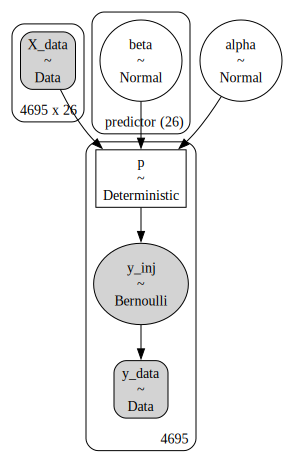

In [5]:
# model specification
with variant_1:
    ## priors (fixed effects)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='predictor')
    alpha = pm.Normal("alpha", mu=0, sigma=1)

    ## linear model
    mu = alpha + pm.math.sum(X_data * beta, axis=1)

    ## logit -> prob
    p = pm.Deterministic('p', pm.math.sigmoid(mu))

    ## likelihood (our target)
    y_inj = pm.Bernoulli('y_inj', p=p, observed=y_data)

pm.model_to_graphviz(variant_1)

In [6]:
## prior predictive checks and sampling
with variant_1:
    variant_1_prior_trace = pm.sample_prior_predictive(1_000)

Sampling: [alpha, beta, y_inj]


In [7]:
variant_1_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

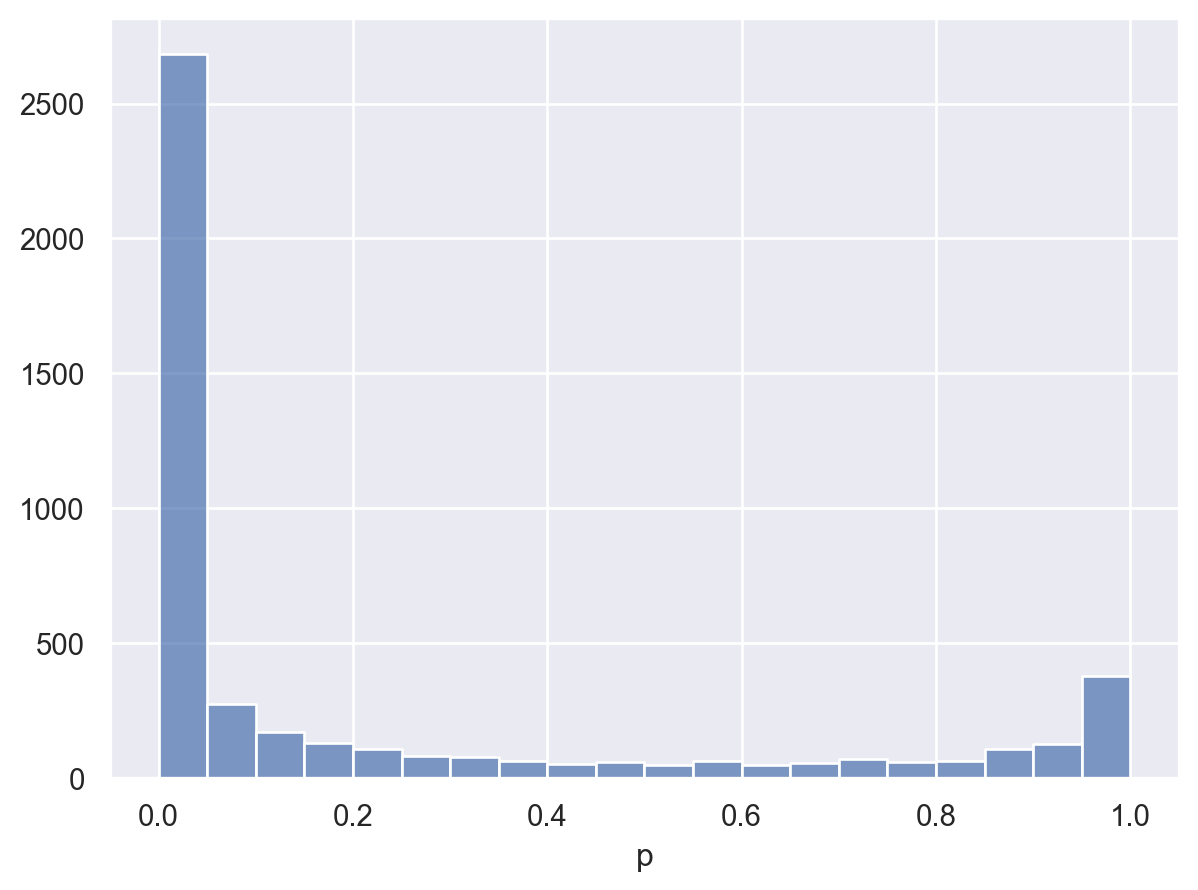

In [8]:
so.Plot(variant_1_prior_trace.prior['p'].sel(chain=[0], draw=[0]).squeeze()).add(so.Bars(), so.Hist(bins=20))

<Axes: xlabel='y_inj'>

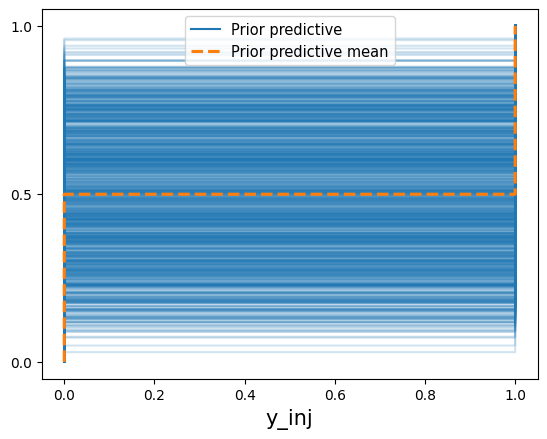

In [9]:
az.plot_ppc(variant_1_prior_trace, group='prior', kind='cumulative')

In [11]:
## MCMC sampling with pymc's NUTS sampler
with variant_1:
    variant_1_trace = pm.sample(sample_kwargs=dict(mode="MLX"))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


In [12]:
az.summary(variant_1_trace).sort_values('mean', ascending=False)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[1865],0.680,0.056,0.569,0.776,0.001,0.001,5528.0,3440.0,1.0
p[3777],0.641,0.054,0.543,0.742,0.001,0.001,4711.0,3529.0,1.0
p[3172],0.572,0.048,0.482,0.662,0.001,0.001,5826.0,3555.0,1.0
p[1535],0.564,0.067,0.437,0.688,0.001,0.001,6716.0,2982.0,1.0
p[3692],0.564,0.055,0.461,0.666,0.001,0.001,6271.0,3535.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[bmi],-0.114,0.039,-0.183,-0.036,0.000,0.001,7458.0,2846.0,1.0
beta[age],-0.123,0.051,-0.219,-0.027,0.001,0.001,5036.0,3365.0,1.0
beta[Δ_num_bf],-0.156,0.044,-0.238,-0.074,0.001,0.001,5672.0,3293.0,1.0
beta[Δ_BB_avg_spin],-0.175,0.064,-0.302,-0.059,0.001,0.001,4532.0,3155.0,1.0


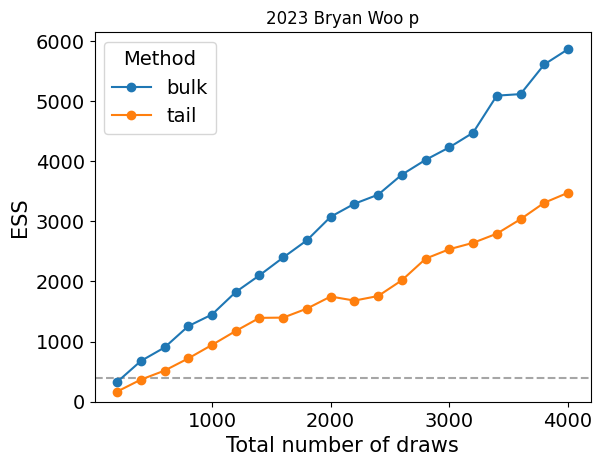

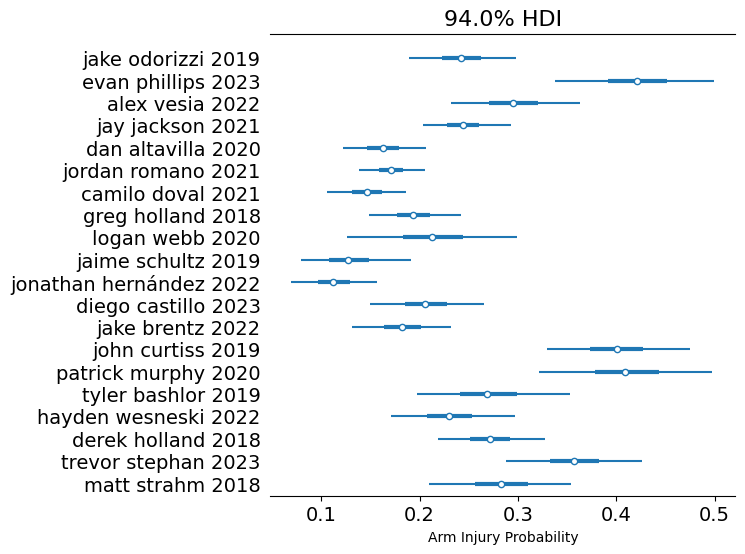

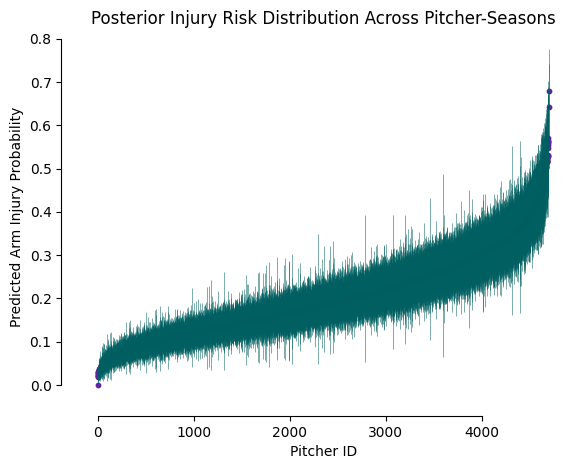

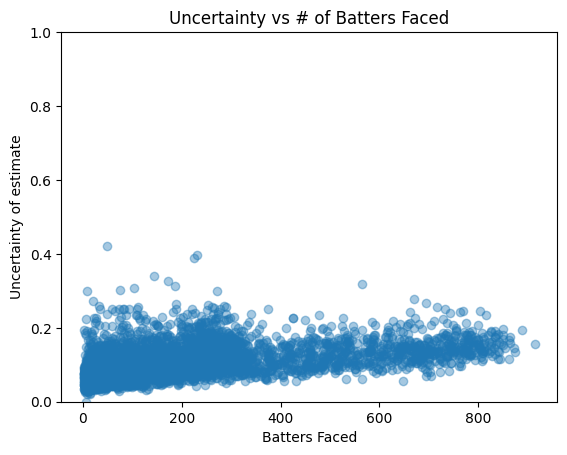

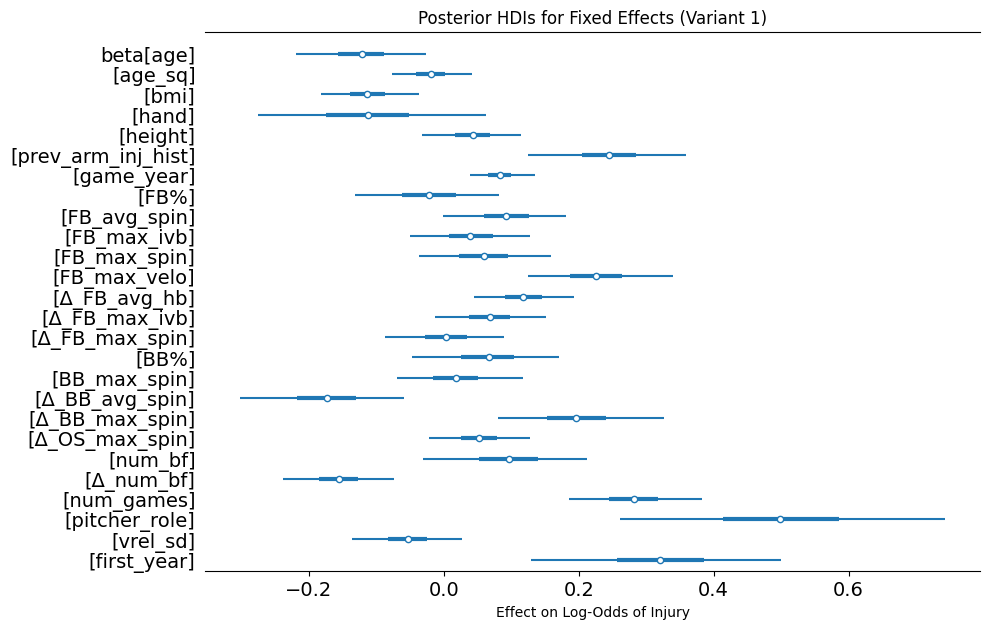

In [13]:
p_dim = variant_1_trace.posterior["p"].dims[-1]

## ESS plot
az.plot_ess(variant_1_trace, var_names=["p"], coords={p_dim: [863]}, kind="evolution")
plt.title("2023 Bryan Woo p")

## forest plot for sample of observations
sample_obs_ids = np.random.choice(variant_1_trace.posterior["p"].shape[-1], size=20, replace=False)
fig = az.plot_forest(variant_1_trace, var_names=["p"], coords={p_dim: sample_obs_ids}, combined=True)
ax = fig[0]
labels = [player_year[i] for i in sample_obs_ids]
ax.set_yticklabels(labels)
ax.set_xlabel("Arm Injury Probability")


## posterior ranking plot
posterior_means = variant_1_trace.posterior.mean(dim=("chain", "draw"))
posterior_hdi    = az.hdi(variant_1_trace)
posterior_means_p = posterior_means["p"]
posterior_hdi_p   = posterior_hdi["p"]
order = posterior_means_p.argsort().values
means_sorted = posterior_means_p[order]
hdi_lower_sorted = posterior_hdi_p.sel(hdi="lower")[order]
hdi_upper_sorted = posterior_hdi_p.sel(hdi="higher")[order]
labels_sorted = player_year[order]
fig, ax = plt.subplots()
x = np.arange(len(means_sorted))
ax.vlines(x, hdi_lower_sorted, hdi_upper_sorted, color=teal_color, alpha=0.6, linewidth=0.6)
ax.scatter(x, means_sorted, color=purple_color, s=10)
ax.set_xlabel("Pitcher ID")
ax.set_ylabel("Predicted Arm Injury Probability")
ax.set_title("Posterior Injury Risk Distribution Across Pitcher-Seasons")
sns.despine(offset=10, trim=True)
plt.show()

## uncertainty vs batters faced plot
uncertainty = posterior_hdi.p.sel(hdi="higher") - posterior_hdi.p.sel(hdi="lower")
mu_pa = train_dict["num_bf"]["mu"]
sigma_pa = train_dict["num_bf"]["sigma"]
bf_raw = pitcher_data_train_z["num_bf"] * sigma_pa + mu_pa
plt.figure()
plt.plot(bf_raw, uncertainty, "o", alpha=0.4)
plt.ylim(0, 1)
plt.xlabel("Batters Faced")
plt.ylabel("Uncertainty of estimate")
plt.title('Uncertainty vs # of Batters Faced')
plt.show()

## HDIs of the coefficients
az.plot_forest(variant_1_trace, var_names=["beta"], combined=True, figsize=(10, 7))
plt.title("Posterior HDIs for Fixed Effects (Variant 1)")
plt.xlabel("Effect on Log-Odds of Injury")
plt.show()

In [14]:
with variant_1:
    pm.sample_posterior_predictive(variant_1_trace, extend_inferencedata=True)

Sampling: [y_inj]


Output()

array([<Axes: xlabel='y_inj'>], dtype=object)

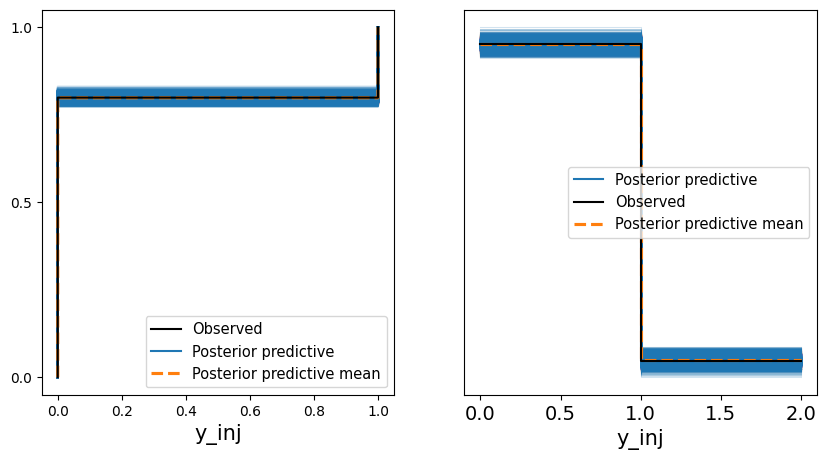

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(variant_1_trace, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(variant_1_trace, group='posterior', ax=axes[1])

### test set evaluation

In [16]:
with variant_1:
    pm.set_data({"X_data": X_test, "y_data": y_test})
    test_ppc = pm.sample_posterior_predictive(variant_1_trace, var_names=["p", "y_inj"],  random_seed=42)

Sampling: [y_inj]


Output()

In [17]:
## provides the predicted posterior means + HDI
p_test_mean = test_ppc.posterior_predictive["p"].mean(dim=("chain", "draw")).values
p_hdi = az.hdi(test_ppc.posterior_predictive["p"])
p_hdi_p = p_hdi["p"]  
lower = p_hdi_p.sel(hdi="lower").values
upper = p_hdi_p.sel(hdi="higher").values
pitcher_data_test_z["pred_injury_prob_v1"] = p_test_mean
pitcher_data_test_z["pred_injury_class_v1"] = (pitcher_data_test_z['pred_injury_prob_v1'] > 0.3).astype(int)
pitcher_data_test_z['hdi_lower_95_v1'] = lower
pitcher_data_test_z['hdi_upper_95_v1'] = upper
pitcher_data_test_z

,player_name,injury_next_year,age,birth_country,bmi,hand,height,prev_arm_inj_hist,game_year,FB%,FB_avg_spin,FB_max_ivb,FB_max_spin,FB_max_velo,Δ_FB_avg_hb,Δ_FB_max_ivb,Δ_FB_max_spin,BB%,BB_max_spin,Δ_BB_avg_spin,Δ_BB_max_spin,Δ_OS_max_spin,num_bf,Δ_num_bf,num_games,pitcher_role,vrel_sd,first_year,age_sq,pred_injury_prob_v1,pred_injury_class_v1,hdi_lower_95_v1,hdi_upper_95_v1
13,a.j. minter,1.0,0.674138,26,0.779215,0,-1.243589,2,6,1.825877,1.251165,0.754662,0.214825,0.267171,-0.171503,0.950469,-0.356445,-2.016723,-6.196050,-0.009607,0.001286,-0.010042,-0.366896,-0.727839,0.749644,0,0.163430,0,0.454462,0.286737,0,0.168130,0.416642
19,a.j. puk,1.0,0.114591,26,0.285446,0,2.149848,2,6,0.003313,-0.046584,-0.254630,0.776908,0.849020,-0.182844,0.760605,1.348734,0.522313,-0.429148,-0.281297,-0.096966,1.065431,0.412046,0.329804,1.902717,0,0.257771,0,0.013131,0.490838,1,0.405215,0.584318
23,aaron ashby,0.0,-0.724730,26,-0.701722,0,-1.243589,2,6,-0.845520,-0.744143,-1.229120,2.332674,0.945994,-0.215026,-1.327907,2.905637,0.177010,0.336859,0.140805,-0.072403,-0.125775,-0.446279,-2.094456,-0.503696,0,-0.413657,0,0.525233,0.362447,1,0.253352,0.466644
30,aaron brooks,0.0,1.513459,26,0.308968,1,0.695518,0,6,-0.419244,-1.834567,-0.602662,-1.297446,-0.153053,-0.058861,0.127722,-0.320988,0.269961,0.014814,0.036302,0.228494,0.145210,-0.446279,0.472408,-0.954898,1,-0.712857,0,2.290559,0.133916,0,0.094283,0.177575
37,aaron bummer,1.0,0.674138,26,-0.145328,0,0.210741,0,6,-0.233461,-0.121800,-1.403136,1.921148,0.105547,0.952525,-0.568448,1.916053,0.924517,1.176476,-0.306298,1.097410,-0.128598,0.173898,-0.103948,1.601915,0,0.610533,0,0.454462,0.363058,1,0.280475,0.442077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6273,zack kelly,0.0,0.114591,26,0.663461,1,0.210741,1,6,-0.458751,0.351166,-0.185024,0.368729,0.945994,3.473091,-0.252007,0.314022,-0.198689,0.826827,0.957814,1.115832,0.153679,0.149091,1.185426,1.250980,0,0.406157,0,0.013131,0.375101,1,0.295122,0.464634
6281,zack littell,0.0,0.114591,26,1.293524,1,0.695518,2,6,-1.582648,-1.342843,0.685056,1.375794,-0.282352,-0.152865,0.380875,2.354435,0.649014,0.589894,0.172125,1.416729,1.375935,2.218000,1.672655,0.248308,1,-0.271385,0,0.013131,0.419668,1,0.315482,0.520764
6285,zack thompson,0.0,-0.444956,26,0.150389,0,-0.274036,0,6,-1.677094,-3.037156,0.371827,-2.123841,-0.443977,0.057746,0.570740,-0.430583,0.763930,0.518584,-1.158153,-0.950530,-0.052383,-0.624890,-1.203184,-0.954898,0,-1.014753,0,0.197986,0.137550,0,0.087308,0.185763
6295,zack wheeler,0.0,1.513459,26,-1.414006,1,0.695518,2,6,0.909244,0.957588,0.859072,0.442335,0.687395,-1.939222,0.887181,-0.166264,-0.503889,0.677306,-0.225388,0.004357,-0.293729,2.877867,0.020830,0.398709,1,0.014791,0,2.290559,0.472154,1,0.373960,0.568022


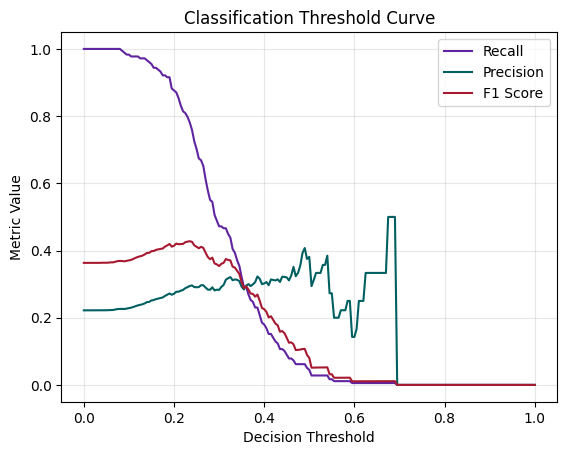

In [18]:
## testing the threshold for a predicted injury to maximize recall
y_true = pitcher_data_test_z["injury_next_year"].values
y_prob = pitcher_data_test_z["pred_injury_prob_v1"].values
thresholds = np.linspace(0, 1, 201)
results = []
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    results.append((t, recall, precision, f1))
results_df = pd.DataFrame(results, columns=["threshold", "recall", "precision", "f1"])

plt.figure()
plt.plot(results_df["threshold"], results_df["recall"], label="Recall", color=purple_color)
plt.plot(results_df["threshold"], results_df["precision"], label="Precision", color=teal_color)
plt.plot(results_df["threshold"], results_df["f1"], label="F1 Score", color=red_color)
plt.xlabel("Decision Threshold")
plt.ylabel("Metric Value")
plt.title("Classification Threshold Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Brier Score: 0.17015513630065945
Log Loss: 0.5165576332003878
AUC: 0.6384057188130221


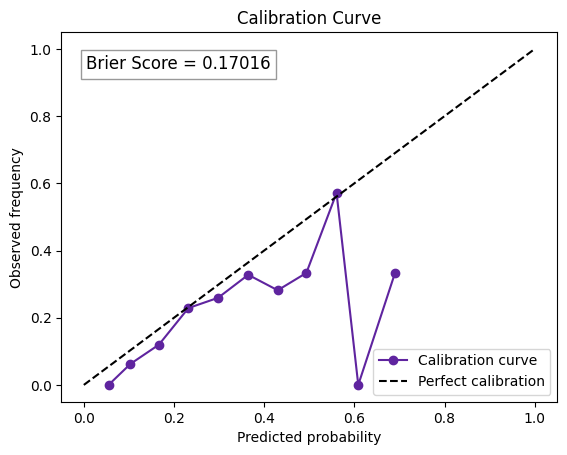

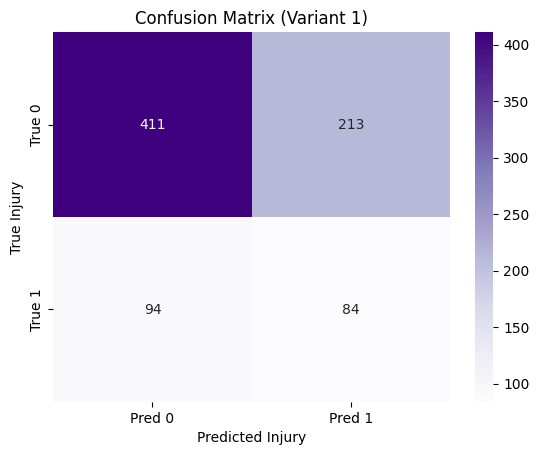

Precision: 0.2828
Recall: 0.4719
F1 Score: 0.3537


In [19]:
y_test = pitcher_data_test_z["injury_next_year"].values
y_pred = pitcher_data_test_z['pred_injury_prob_v1'].values
y_pred_class = pitcher_data_test_z['pred_injury_class_v1'].values

brier_v1 = brier_score_loss(y_test, y_pred)
print("Brier Score:", brier_v1)
logloss_v1 = log_loss(y_test, y_pred)
print("Log Loss:", logloss_v1)
auc_v1 = roc_auc_score(y_test, y_pred)
print("AUC:", auc_v1)

prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=15)
plt.figure()
plt.plot(prob_pred, prob_true, "o-", label="Calibration curve", color=purple_color)
plt.plot([0,1], [0,1], "--", color="k", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.text(0.05, 0.90, f"Brier Score = {brier_v1:.5f}", fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
plt.legend()
plt.show()

cm_v1 = confusion_matrix(y_test, y_pred_class)
plt.figure()
sns.heatmap(cm_v1, annot=True, fmt="d", cmap="Purples", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Variant 1)")
plt.ylabel("True Injury")
plt.xlabel("Predicted Injury")
plt.show()

precision_v1 = precision_score(y_test, y_pred_class, zero_division=0)
print(f"Precision: {precision_v1:.4f}")
recall_v1 = recall_score(y_test, y_pred_class, zero_division=0)
print(f"Recall: {recall_v1:.4f}")
f1_v1 = f1_score(y_test, y_pred_class, zero_division=0)
print(f"F1 Score: {f1_v1:.4f}")

In [21]:
pitcher_data_test_z.sort_values("pred_injury_prob_v1", ascending=False).head(20)

,player_name,injury_next_year,age,birth_country,bmi,hand,height,prev_arm_inj_hist,game_year,FB%,FB_avg_spin,FB_max_ivb,FB_max_spin,FB_max_velo,Δ_FB_avg_hb,Δ_FB_max_ivb,Δ_FB_max_spin,BB%,BB_max_spin,Δ_BB_avg_spin,Δ_BB_max_spin,Δ_OS_max_spin,num_bf,Δ_num_bf,num_games,pitcher_role,vrel_sd,first_year,age_sq,pred_injury_prob_v1,pred_injury_class_v1,hdi_lower_95_v1,hdi_upper_95_v1
3990,luke weaver,0.0,0.674138,26,-1.666977,1,-0.274036,4,6,0.953686,1.408553,1.207104,0.776908,0.687395,1.190549,1.140334,0.575118,-1.904941,0.592195,0.901654,1.278562,0.164970,0.605541,-1.363613,1.902717,0,-0.298048,0,0.454462,0.705803,1,0.599341,0.819644
4264,michael kopech,1.0,-0.165183,26,0.107418,1,0.210741,4,6,2.342305,2.216592,0.998285,0.750142,2.142016,0.551966,-0.568448,0.346256,-1.285152,0.104527,0.676287,0.311394,-2.814456,0.347547,-1.833016,2.153385,0,-0.303381,0,0.027285,0.694375,1,0.569574,0.811280
151,adrian morejon,0.0,-1.004504,5,1.621391,0,-1.728366,4,6,0.489049,1.228233,0.337024,0.499212,1.172269,4.904588,-1.011466,0.230214,0.358960,1.404208,0.554340,1.585600,-2.590047,0.307856,1.369622,1.802450,0,0.234626,0,1.009027,0.670317,1,0.511184,0.817841
2120,freddy peralta,0.0,-0.165183,8,-0.153227,1,-1.243589,3,6,-0.304532,1.172404,1.485529,0.348654,1.010644,0.058970,2.279522,0.004576,-0.104430,-0.166911,0.112345,0.130242,0.616612,2.570260,0.300095,0.398709,1,1.438882,0,0.027285,0.620752,1,0.514722,0.722034
3879,lucas sims,0.0,0.394365,26,0.046539,1,-0.274036,2,6,-0.830583,2.511993,0.545843,1.111481,0.331821,2.943968,-0.695025,0.072267,1.514577,2.034495,0.570373,0.741247,2.862119,0.034978,-0.228726,1.702182,0,-0.382832,0,0.155523,0.606975,1,0.498952,0.715484
1205,chris sale,0.0,1.793233,26,-2.601008,0,1.665072,4,6,-0.937617,-0.183273,-0.150221,0.606276,0.913669,0.047338,0.634028,1.158553,0.675739,0.028616,0.390217,0.452631,-0.036858,2.456147,1.672655,0.248308,1,1.297648,0,3.215684,0.605833,1,0.478494,0.722264
5071,ryan helsley,0.0,0.394365,26,1.188884,1,-0.274036,3,6,-0.940303,1.876358,0.615450,0.422261,2.432941,0.068130,-0.252007,-0.295200,1.627006,0.044718,-0.108503,0.111820,0.114160,0.268165,0.710080,2.053118,0,-0.207516,0,0.155523,0.600995,1,0.507452,0.698117
4612,pablo lópez,1.0,-0.165183,29,0.062829,1,0.695518,3,6,-0.740373,-0.342905,0.441434,-0.390752,0.849020,0.144447,0.760605,0.040033,0.110058,0.622099,-0.180367,-0.050910,0.111337,2.803446,-0.133657,0.398709,1,0.194478,0,0.027285,0.594667,1,0.496726,0.693191
4272,michael lorenzen,0.0,0.953912,26,-0.044230,1,0.210741,3,6,0.029386,0.753843,0.406630,0.452372,0.234846,1.002041,0.697316,-0.414466,-0.490921,1.496220,0.356632,1.453574,-0.398171,1.632553,-0.496108,0.097907,1,-0.160174,0,0.909948,0.584488,1,0.493327,0.682333
3181,jorge alcala,0.0,0.114591,8,-0.650822,1,0.210741,3,6,-0.479451,1.087278,0.789465,0.298469,1.689467,0.612661,0.760605,0.423618,0.565447,0.053920,-0.041979,0.121031,0.142388,0.139168,0.983404,1.501648,0,-0.328523,0,0.013131,0.569800,1,0.483074,0.655392


## Variant 2 Model: Bayesian Logistic Regression with Pitcher-Level Random Intercept

In [22]:
## creating the pitcher idx for grouping
pitcher_idx, pitcher_names = pd.factorize(pitcher_data_train_z["player_name"])
pitcher_data_train_z["pitcher_idx"] = pitcher_idx
pitcher_to_idx = {name: i for i, name in enumerate(pitcher_names)}
unknown_pitcher_idx = len(pitcher_names)

pitcher_data_test_z["pitcher_idx"] = (pitcher_data_test_z["player_name"].map(pitcher_to_idx))
pitcher_data_test_z["pitcher_idx"] = (pitcher_data_test_z["pitcher_idx"].fillna(unknown_pitcher_idx).astype(int))

In [23]:
coords_v2 = {"predictor": predictor_cols, 
             "pitcher": list(pitcher_names) + ["__NEW_PITCHER__"],  
             }

with pm.Model(coords=coords_v2) as variant_2:
    X_data = pm.Data("X_data", X_train,)
    y_data = pm.Data("y_data", y_train,)
    pitcher_id = pm.Data("pitcher_id", pitcher_idx)

In [24]:
print("Max pitcher_idx in test:", pitcher_data_test_z["pitcher_idx"].max())
print("Pitcher coord size:", len(variant_2.coords["pitcher"]))

Max pitcher_idx in test: 1577
Pitcher coord size: 1578


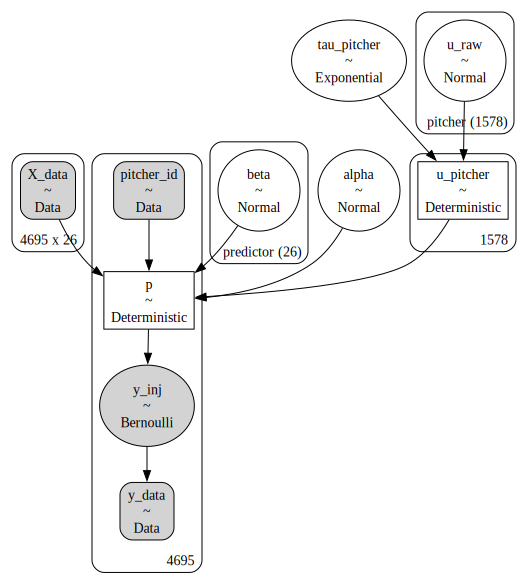

In [25]:
# model specification
with variant_2:
    ## priors (fixed effects)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='predictor')
    alpha = pm.Normal("alpha", mu=0, sigma=1)

    ## random pitcher intercept (with non-centered reparameterization)
    u_raw = pm.Normal("u_raw", 0, 1, dims="pitcher")
    tau_pitcher = pm.Exponential("tau_pitcher", 1)
    u_pitcher = pm.Deterministic("u_pitcher", tau_pitcher * u_raw)

    ## linear model
    mu = alpha + u_pitcher[pitcher_id] + pm.math.sum(X_data * beta, axis=1)

    ## logit -> prob
    p = pm.Deterministic('p', pm.math.sigmoid(mu))

    ## likelihood (our target)
    y_inj = pm.Bernoulli('y_inj', p=p, observed=y_data)

pm.model_to_graphviz(variant_2)

In [26]:
## prior predictive checks and sampling
with variant_2:
    variant_2_prior_trace = pm.sample_prior_predictive(1_000)

variant_2_prior_trace

Sampling: [alpha, beta, tau_pitcher, u_raw, y_inj]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

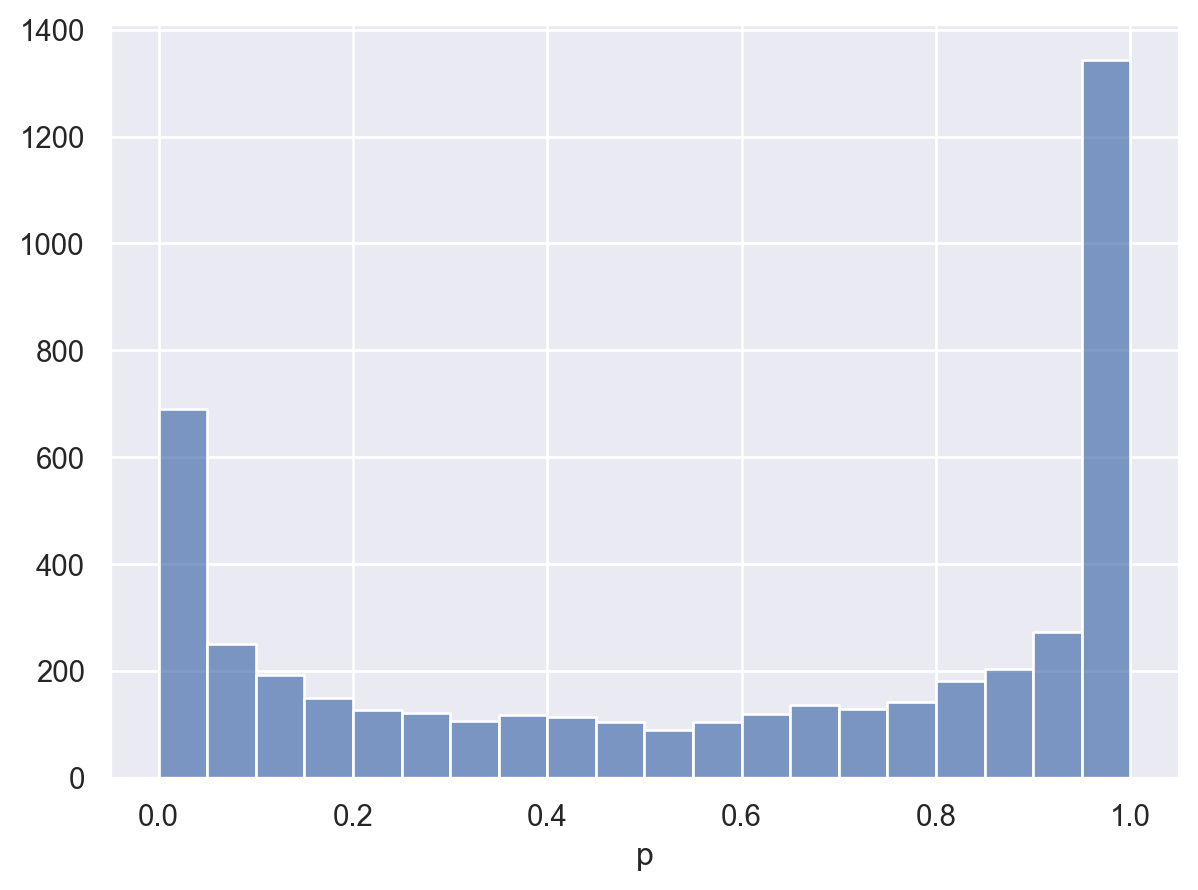

In [27]:
so.Plot(variant_2_prior_trace.prior["p"].sel(chain=0, draw=0).squeeze()).add(so.Bars(), so.Hist(bins=20))

<Axes: xlabel='y_inj'>

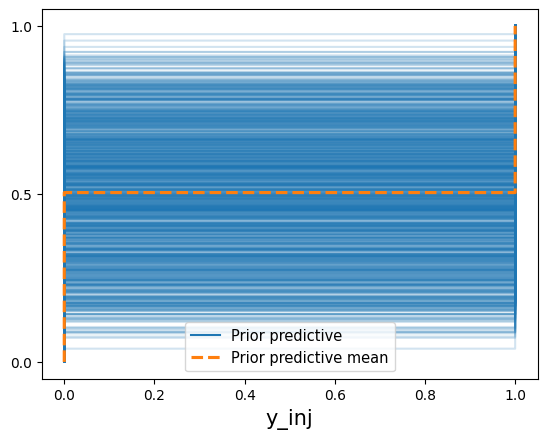

In [28]:
az.plot_ppc(variant_2_prior_trace, group="prior", kind="cumulative")

In [29]:
## MCMC sampling
with variant_2:
    variant_2_trace = pm.sample(draws=2000, tune=2000, target_accept = 0.90, sample_kwargs=dict(mode="MLX")) ## more samples w/ higher target to avoid divergences

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, u_raw, tau_pitcher]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 287 seconds.


In [30]:
az.summary(variant_2_trace).sort_values("mean", ascending=False)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u_raw[kyle crick],1.453,0.849,-0.180,3.001,0.007,0.012,15174.0,5700.0,1.0
u_raw[john means],1.421,0.841,-0.133,3.013,0.007,0.012,14213.0,5490.0,1.0
u_raw[wade miley],1.401,0.829,-0.136,2.946,0.006,0.011,17518.0,5504.0,1.0
u_raw[clayton kershaw],1.279,0.784,-0.198,2.735,0.006,0.010,15030.0,5663.0,1.0
u_raw[austin warren],1.263,0.915,-0.476,2.973,0.007,0.012,16201.0,5484.0,1.0
...,...,...,...,...,...,...,...,...,...
u_raw[aaron nola],-0.880,0.846,-2.457,0.704,0.007,0.011,16285.0,5762.0,1.0
u_raw[emmanuel clase],-0.882,0.844,-2.437,0.739,0.006,0.011,18847.0,5508.0,1.0
u_raw[edwin díaz],-0.898,0.851,-2.476,0.743,0.006,0.012,17160.0,5121.0,1.0
u_raw[dylan cease],-0.990,0.856,-2.599,0.653,0.006,0.012,18569.0,5150.0,1.0


In [31]:
## finding the paramaters that had rhat > 1.01 and ESS per chain < 100 (yes, this is a little inefficient)
# az.summary(variant_2_trace).sort_values("mean", ascending=False)[(az.summary(variant_2_trace).sort_values("mean", ascending=False)['r_hat'] > 1.01) | 
#                                                                  (az.summary(variant_2_trace).sort_values("mean", ascending=False)['ess_bulk'] < 100) | 
#                                                                  (az.summary(variant_2_trace).sort_values("mean", ascending=False)['ess_tail'] < 100)
#                                                                  ]

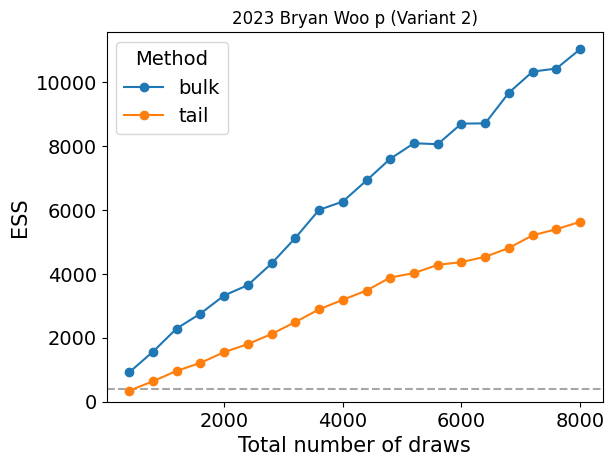

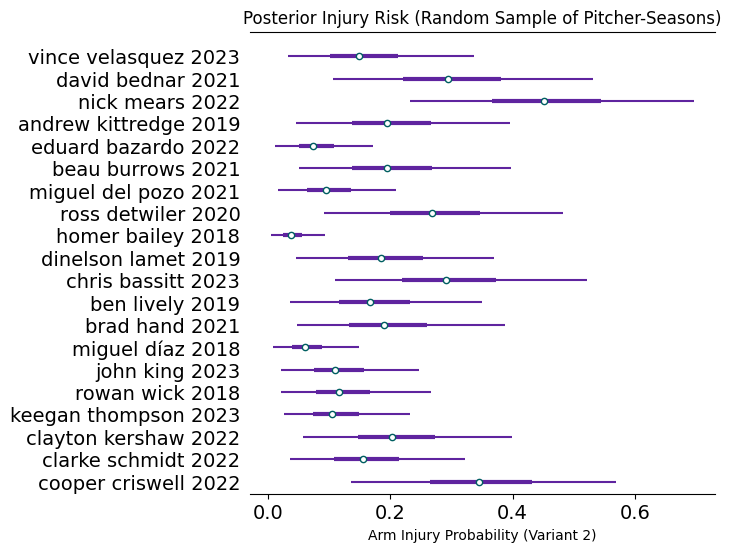

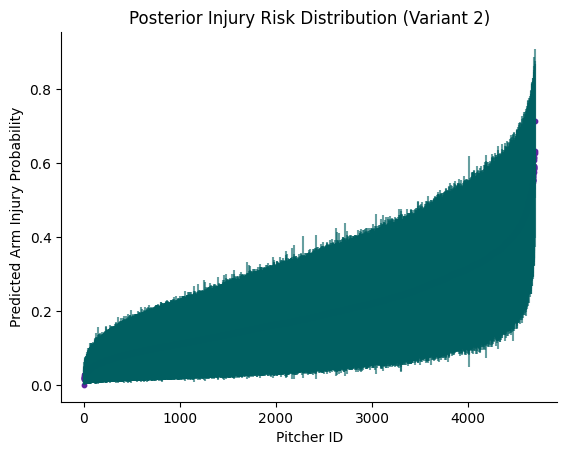

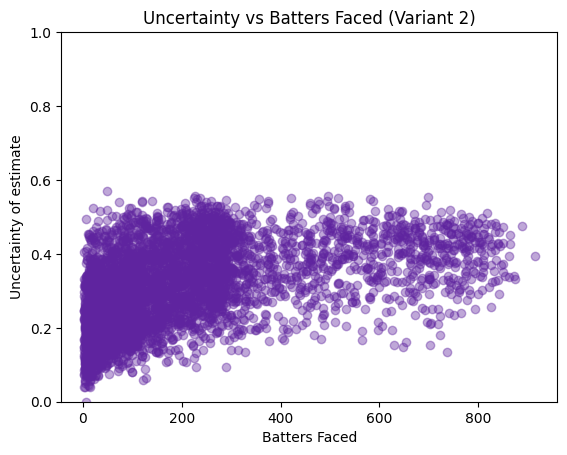

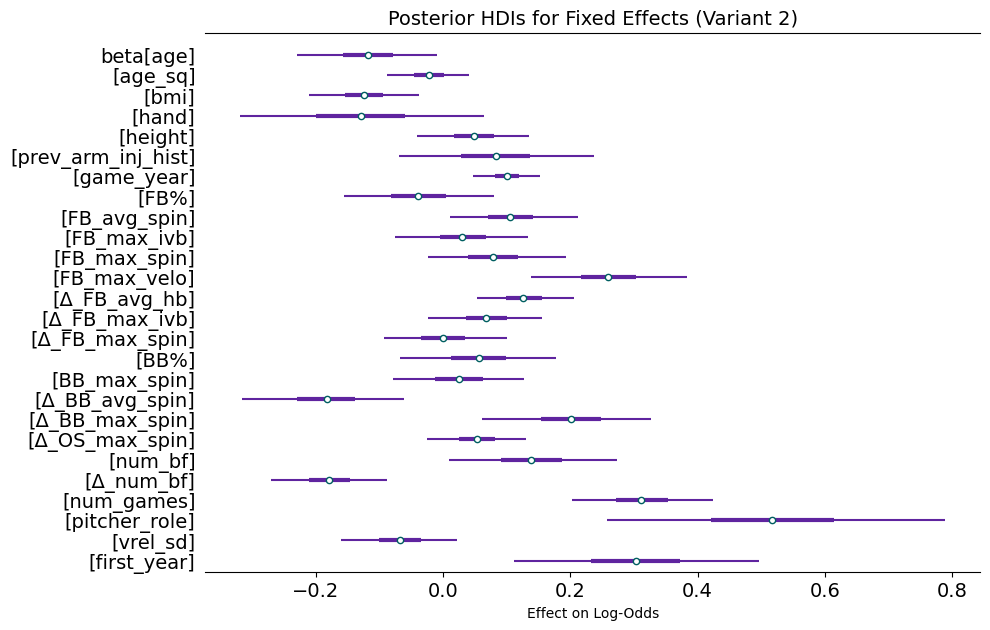

In [32]:
p_dim = variant_2_trace.posterior["p"].dims[-1]

## ESS plot
az.plot_ess(variant_2_trace, var_names=["p"], coords={p_dim: [863]}, kind="evolution")
plt.title("2023 Bryan Woo p (Variant 2)")

## forest plot for sample of observations
sample_obs_ids = np.random.choice(variant_2_trace.posterior["p"].shape[-1], size=20, replace=False)
fig = az.plot_forest(variant_2_trace, var_names=["p"], coords={p_dim: sample_obs_ids}, combined=True)
ax = fig[0]
labels = [player_year[i] for i in sample_obs_ids]
ax.set_yticklabels(labels)
for line in ax.lines:
    line.set_color(teal_color)
for coll in ax.collections:
    coll.set_color(purple_color)
ax.set_xlabel("Arm Injury Probability (Variant 2)")
ax.set_title("Posterior Injury Risk (Random Sample of Pitcher-Seasons)")
plt.show()

## posterior ranking plot
posterior_means = variant_2_trace.posterior.mean(dim=("chain", "draw"))
posterior_hdi = az.hdi(variant_2_trace)
posterior_means_p = posterior_means["p"]
posterior_hdi_p = posterior_hdi["p"]
order = posterior_means_p.argsort().values
means_sorted = posterior_means_p[order]
hdi_lower_sorted = posterior_hdi_p.sel(hdi="lower")[order]
hdi_upper_sorted = posterior_hdi_p.sel(hdi="higher")[order]
labels_sorted = player_year[order]

fig, ax = plt.subplots()
x = np.arange(len(means_sorted))
ax.vlines(x, hdi_lower_sorted, hdi_upper_sorted, color=teal_color, alpha=0.6)
ax.scatter(x, means_sorted, color=purple_color, s=10)
ax.set_xlabel("Pitcher ID")
ax.set_ylabel("Predicted Arm Injury Probability")
ax.set_title("Posterior Injury Risk Distribution (Variant 2)")
sns.despine()
plt.show()

## uncertainty vs batters faced plot
uncertainty = posterior_hdi_p.sel(hdi="higher") - posterior_hdi_p.sel(hdi="lower")
plt.figure()
plt.plot(bf_raw, uncertainty, "o", alpha=0.4, color=purple_color)
plt.ylim(0, 1)
plt.xlabel("Batters Faced")
plt.ylabel("Uncertainty of estimate")
plt.title("Uncertainty vs Batters Faced (Variant 2)")
plt.show()

## HDIs of parameters
axes = az.plot_forest(variant_2_trace, var_names=["beta"], combined=True, figsize=(10, 7))
ax = axes[0] if hasattr(axes, "__len__") and not isinstance(axes, plt.Axes) else axes
for line in ax.lines:
    line.set_color(teal_color)
for coll in ax.collections:
    coll.set_color(purple_color)
ax.set_title("Posterior HDIs for Fixed Effects (Variant 2)", fontsize=14)
ax.set_xlabel("Effect on Log-Odds")
plt.show()

In [33]:
# with variant_2:
#     pm.sample_posterior_predictive(variant_2_trace, extend_inferencedata=True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(variant_2_trace, group="posterior", kind="cumulative", ax=axes[0])
az.plot_ppc(variant_2_trace, group="posterior", ax=axes[1])

### test set evaluation

In [34]:
with variant_2:
    pm.set_data({"X_data": X_test, "y_data": y_test, "pitcher_id": pitcher_data_test_z["pitcher_idx"].values,})
    test_ppc_v2 = pm.sample_posterior_predictive(variant_2_trace, var_names=["p"], extend_inferencedata=False, random_seed=42,)

Sampling: []


Output()

In [35]:
## provides the predicted posterior means + HDI
p_test_mean_v2 = test_ppc_v2.posterior_predictive["p"].mean(dim=("chain", "draw")).values
p_hdi_v2 = az.hdi(test_ppc_v2.posterior_predictive["p"])
p_hdi_p = p_hdi_v2["p"]
lower_v2 = p_hdi_p.sel(hdi="lower").values
upper_v2 = p_hdi_p.sel(hdi="higher").values
pitcher_data_test_z["pred_injury_prob_v2"] = p_test_mean_v2
pitcher_data_test_z['hdi_lower_95_v2'] = lower_v2
pitcher_data_test_z['hdi_upper_95_v2'] = upper_v2

y_test_v2 = pitcher_data_test_z["injury_next_year"].values
y_pred_v2 = pitcher_data_test_z['pred_injury_prob_v2'].values

Brier Score: 0.1668441091011972
Log Loss: 0.5074615421043862
AUC: 0.6635335638144627


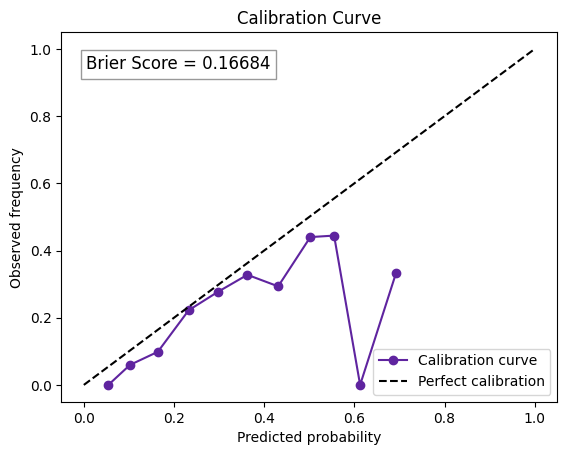

In [36]:
brier_v2 = brier_score_loss(y_test_v2, y_pred_v2)
print("Brier Score:", brier_v2)
logloss_v2 = log_loss(y_test_v2, y_pred_v2)
print("Log Loss:", logloss_v2)
auc_v2 = roc_auc_score(y_test_v2, y_pred_v2)
print("AUC:", auc_v2)

prob_true, prob_pred = calibration_curve(y_test_v2, y_pred_v2, n_bins=15)
plt.figure()
plt.plot(prob_pred, prob_true, "o-", label="Calibration curve", color=purple_color)
plt.plot([0,1], [0,1], "--", color="k", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.text(0.05, 0.90, f"Brier Score = {brier_v2:.5f}", fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
plt.legend()
plt.show()

Precision: 0.3129251700680272
Recall: 0.5168539325842697
F1 Score: 0.3898305084745763


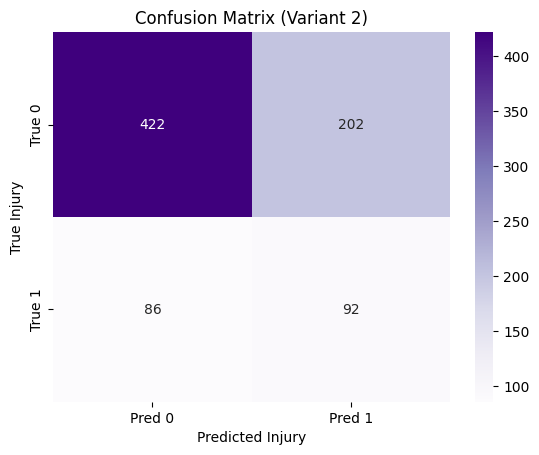

In [37]:
pitcher_data_test_z.sort_values("pred_injury_prob_v2", ascending=False).head(20)
pitcher_data_test_z['pred_injury_class_v2'] = (pitcher_data_test_z['pred_injury_prob_v2'] > 0.3).astype(int)

y_true = pitcher_data_test_z["injury_next_year"].values
y_pred = pitcher_data_test_z["pred_injury_class_v2"].values
cm_v2 = confusion_matrix(y_true, y_pred)

precision_v2 = precision_score(y_true, y_pred, zero_division=0)
print("Precision:", precision_v2)
recall_v2 = recall_score(y_true, y_pred, zero_division=0)
print("Recall:", recall_v2)
f1_v2 = f1_score(y_true, y_pred, zero_division=0)
print("F1 Score:", f1_v2)

plt.figure()
sns.heatmap(cm_v2, annot=True, fmt="d", cmap="Purples", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Variant 2)")
plt.ylabel("True Injury")
plt.xlabel("Predicted Injury")
plt.show()

## Variant 3 Model: Bayesian Logistic Regression with Group-Level Random Effects

In [60]:
## takes out role & injury
v3_predictor_cols = [
    'bmi', 'hand', 'height',
    'game_year', 'FB%', 'FB_avg_spin', 'FB_max_ivb',
    'FB_max_spin', 'FB_max_velo', 'Δ_FB_avg_hb',
    'Δ_FB_max_ivb', 'Δ_FB_max_spin', 'BB%', 'BB_max_spin',
    'Δ_BB_avg_spin', 'Δ_BB_max_spin', 'Δ_OS_max_spin',
    'num_bf', 'Δ_num_bf', 'num_games', 'vrel_sd', 'first_year'
]

X_train_v3 = pitcher_data_train_z[v3_predictor_cols].values
X_test_v3 = pitcher_data_test_z[v3_predictor_cols].values

# Pitcher index
pitcher_idx, pitcher_names = pd.factorize(pitcher_data_train_z["player_name"])
pitcher_data_train_z["pitcher_idx"] = pitcher_idx
pitcher_to_idx = {name: i for i, name in enumerate(pitcher_names)}
unknown_pitcher_idx = len(pitcher_names)
pitcher_data_test_z["pitcher_idx"] = (pitcher_data_test_z["player_name"].map(pitcher_to_idx).fillna(unknown_pitcher_idx).astype(int))

# Role index
role_id_train = pitcher_data_train_z["pitcher_role"].astype(int).values
role_id_test = pitcher_data_test_z["pitcher_role"].astype(int).values
n_roles = 2  # RP=0, SP=1

# Injury history index
injhist_id_train = pitcher_data_train_z["prev_arm_inj_hist"].astype(int).values
injhist_id_test = pitcher_data_test_z["prev_arm_inj_hist"].astype(int).values
n_injhist = pitcher_data_train_z["prev_arm_inj_hist"].nunique()

In [61]:
coords_v3 = {"predictor": v3_predictor_cols, 
             "pitcher": list(pitcher_names) + ["__NEW_PITCHER__"], 
             "role": [0, 1], 
             "injhist": sorted(pitcher_data_train_z["prev_arm_inj_hist"].unique()),
             }

with pm.Model(coords=coords_v3) as variant_3:
    X_data = pm.Data("X_data", X_train_v3)
    y_data = pm.Data("y_data", y_train)
    pitcher_id = pm.Data("pitcher_id", pitcher_data_train_z["pitcher_idx"].values)
    role_id = pm.Data("role_id", role_id_train)
    injhist_id = pm.Data("injhist_id", injhist_id_train)

In [62]:
with variant_3:
    alpha = pm.Normal('alpha', 0, 1) ## the model intercept (the population average)
    beta = pm.Normal('beta', 0, 1, dims = 'predictor') ## fixed effects params

    ## polynomial age effect
    beta_age1 = pm.Normal('beta_age1', 0, 0.5)
    beta_age2 = pm.Normal('beta_age2', 0, 0.1)

    ## random effects (non-centered for MCMC ease)
    ### pitcher random effect
    u_raw = pm.Normal("u_raw", 0, 1, dims="pitcher")
    tau_pitcher = pm.Exponential("tau_pitcher", 1)
    u_pitcher = pm.Deterministic("u_pitcher", u_raw * tau_pitcher)

    ### role random effect
    gamma_raw = pm.Normal("gamma_raw", 0, 1, dims="role")
    tau_role = pm.HalfCauchy("tau_role", 2.5)
    gamma_role = pm.Deterministic("gamma_role", gamma_raw * tau_role)

    ### injury history random effect
    kappa_raw = pm.Normal("kappa_raw", 0, 1, dims="injhist")
    tau_inj = pm.HalfCauchy("tau_inj", 2.5)
    kappa_inj = pm.Deterministic("kappa_inj", kappa_raw * tau_inj)

    ## linear model
    mu = (alpha + 
          u_pitcher[pitcher_id] + 
          gamma_role[role_id] 
          + kappa_inj[injhist_id] 
          + beta_age1 * pitcher_data_train_z["age"].values
          + beta_age2 * pitcher_data_train_z["age_sq"].values
          + pm.math.sum(X_data * beta, axis=1)
          )
    
    ## logit link
    p = pm.Deterministic("p", pm.math.sigmoid(mu))

    ## likelihood
    y_inj = pm.Bernoulli("y_inj", p=p, observed=y_data)

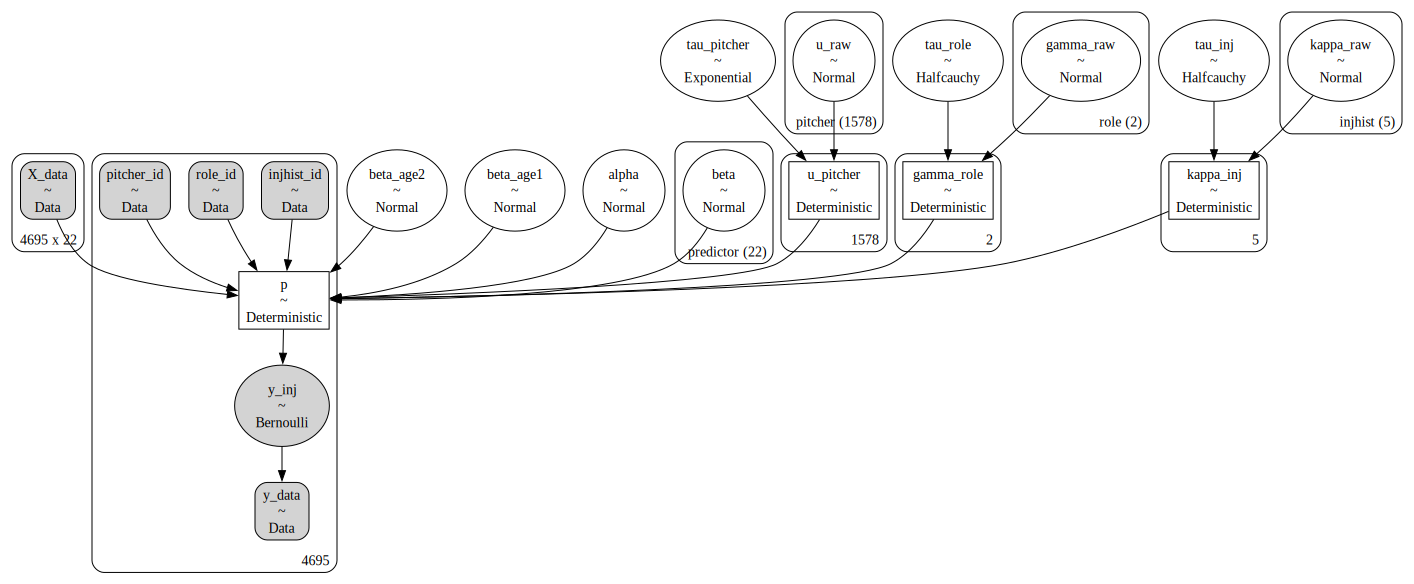

In [63]:
pm.model_to_graphviz(variant_3)

In [64]:
with variant_3:
    variant_3_prior_trace = pm.sample_prior_predictive(1_000)

Sampling: [alpha, beta, beta_age1, beta_age2, gamma_raw, kappa_raw, tau_inj, tau_pitcher, tau_role, u_raw, y_inj]


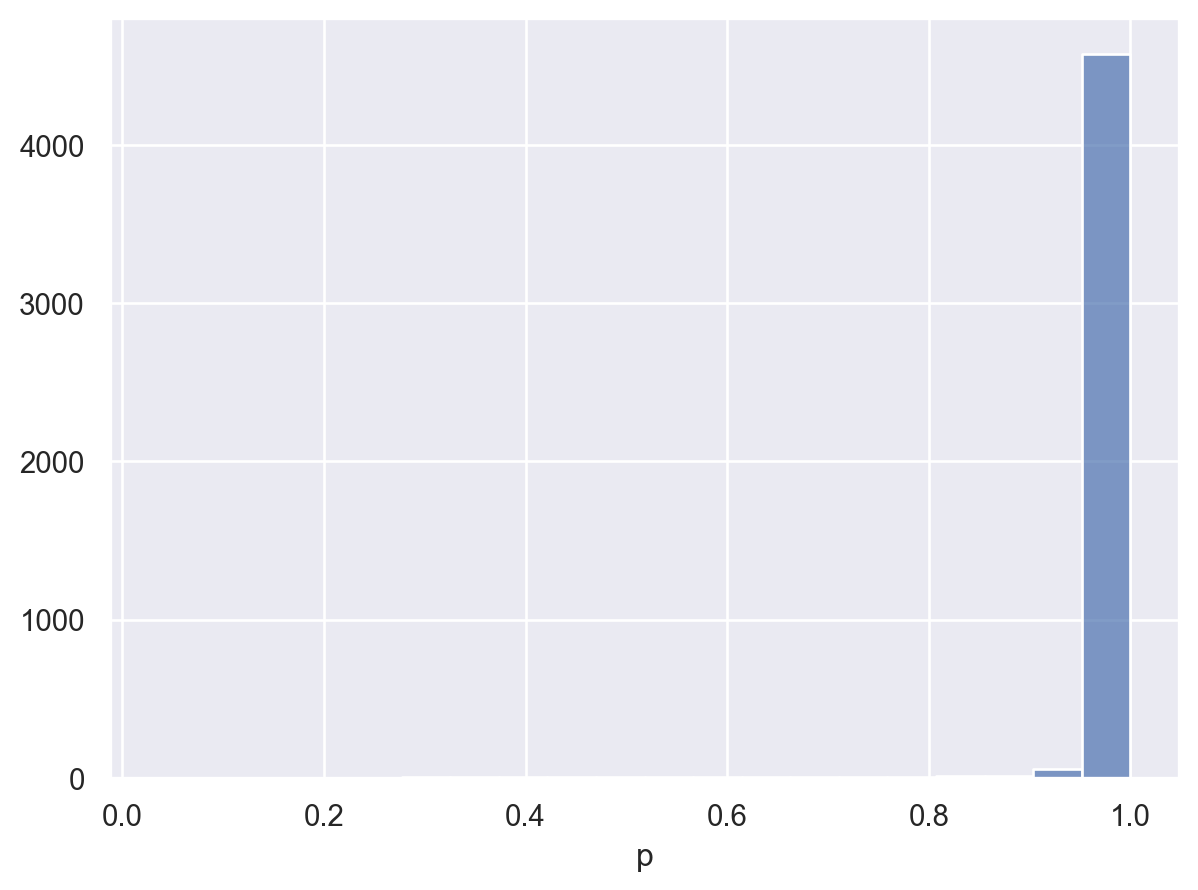

In [65]:
so.Plot(variant_3_prior_trace.prior["p"].sel(chain=0, draw=0).squeeze()).add(so.Bars(), so.Hist(bins=20))

<Axes: xlabel='y_inj'>

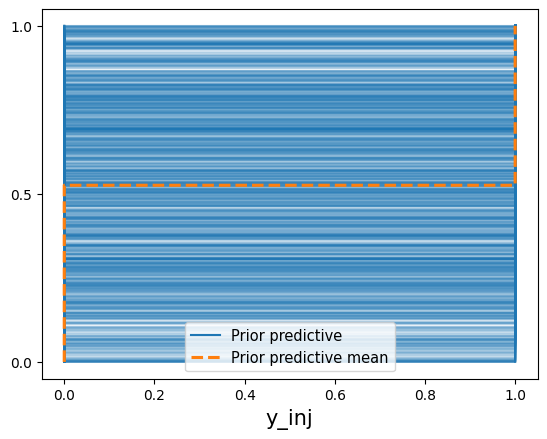

In [54]:
az.plot_ppc(variant_3_prior_trace, group="prior", kind="cumulative")

In [66]:
## mcmc sampling
with variant_3:
    variant_3_trace = pm.sample(draws=1000, tune=1000, target_accept=0.95, sample_kwargs=dict(mode="MLX"))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, beta_age1, beta_age2, u_raw, tau_pitcher, gamma_raw, tau_role, kappa_raw, tau_inj]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 930 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


In [67]:
az.summary(variant_3_trace).sort_values("mean", ascending=False)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u_raw[john means],1.480,0.820,-0.013,3.017,0.010,0.016,7416.0,2714.0,1.0
tau_role,1.474,1.254,0.069,3.766,0.030,0.035,1550.0,2580.0,1.0
u_raw[kyle crick],1.467,0.848,-0.052,3.089,0.011,0.015,5751.0,2960.0,1.0
u_raw[wade miley],1.403,0.850,-0.153,3.060,0.010,0.016,7765.0,2920.0,1.0
u_raw[clayton kershaw],1.300,0.792,-0.237,2.733,0.010,0.014,5981.0,2629.0,1.0
...,...,...,...,...,...,...,...,...,...
u_raw[emmanuel clase],-0.873,0.865,-2.553,0.703,0.009,0.014,8284.0,3143.0,1.0
u_raw[edwin díaz],-0.876,0.875,-2.483,0.766,0.011,0.016,6395.0,3077.0,1.0
u_raw[dylan cease],-0.975,0.843,-2.575,0.573,0.010,0.016,7671.0,2480.0,1.0
gamma_role[0],-0.978,0.838,-2.697,0.330,0.021,0.014,1500.0,2326.0,1.0


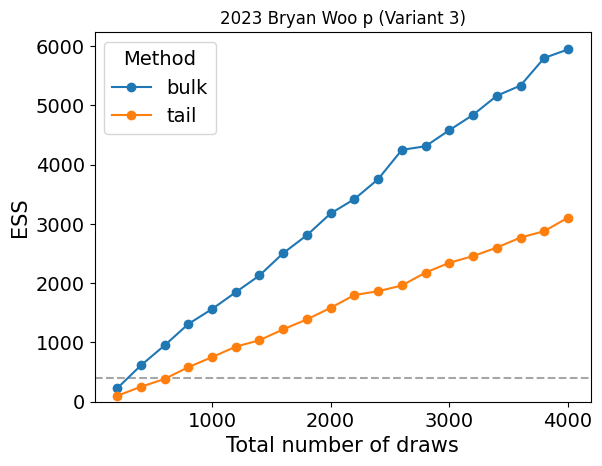

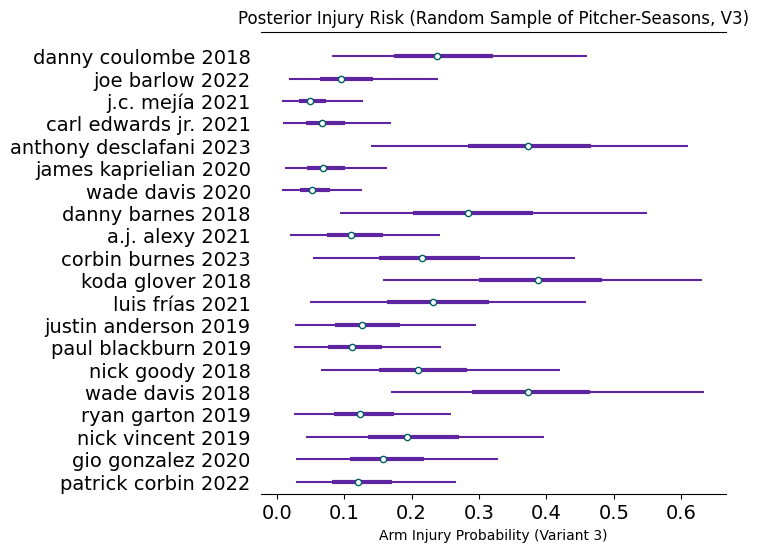

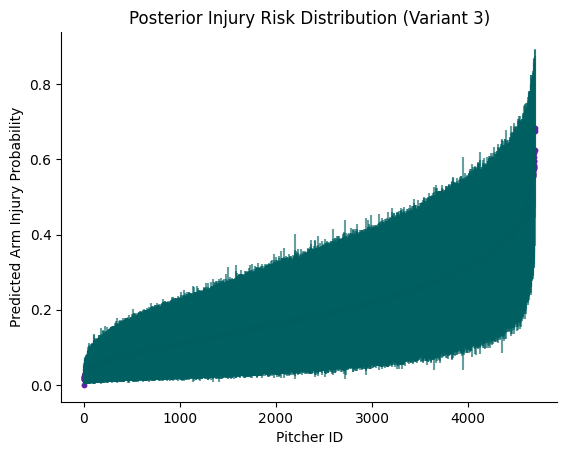

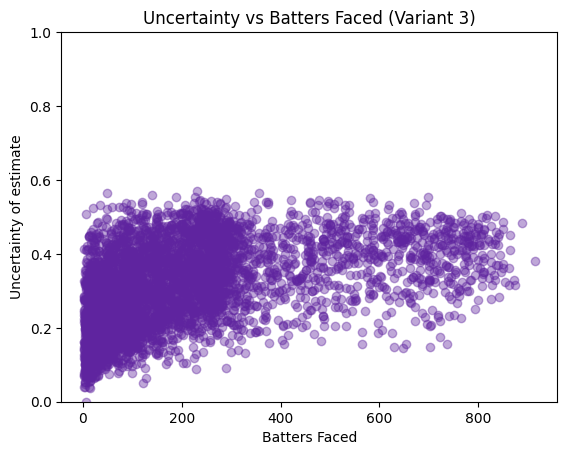

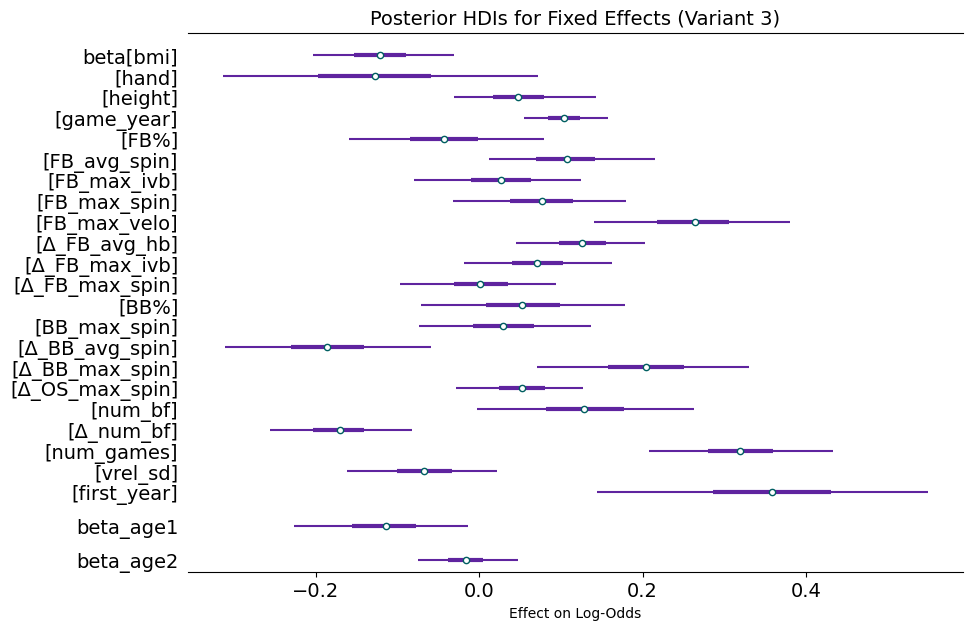

In [68]:
p_dim_v3 = variant_3_trace.posterior["p"].dims[-1]

## ESS plot
az.plot_ess(variant_3_trace, var_names=["p"], coords={p_dim_v3: [863]}, kind="evolution")
plt.title("2023 Bryan Woo p (Variant 3)")

## forest plot for sample of observations
sample_obs_ids_v3 = np.random.choice(variant_3_trace.posterior["p"].shape[-1], size=20, replace=False)
fig = az.plot_forest(variant_3_trace, var_names=["p"], coords={p_dim_v3: sample_obs_ids_v3}, combined=True)
ax = fig[0]
labels = [player_year[i] for i in sample_obs_ids_v3]
ax.set_yticklabels(labels)
for line in ax.lines:
    line.set_color(teal_color)
for coll in ax.collections:
    coll.set_color(purple_color)
ax.set_xlabel("Arm Injury Probability (Variant 3)")
ax.set_title("Posterior Injury Risk (Random Sample of Pitcher-Seasons, V3)")
plt.show()

## posterior ranking plot
posterior_means_v3 = variant_3_trace.posterior.mean(dim=("chain", "draw"))
posterior_hdi_v3   = az.hdi(variant_3_trace)
posterior_means_p_v3 = posterior_means_v3["p"]
posterior_hdi_p_v3   = posterior_hdi_v3["p"]
order_v3 = posterior_means_p_v3.argsort().values
means_sorted_v3      = posterior_means_p_v3[order_v3]
hdi_lower_sorted_v3  = posterior_hdi_p_v3.sel(hdi="lower")[order_v3]
hdi_upper_sorted_v3  = posterior_hdi_p_v3.sel(hdi="higher")[order_v3]
labels_sorted_v3     = player_year[order_v3]
fig, ax = plt.subplots()
x = np.arange(len(means_sorted_v3))
ax.vlines(x, hdi_lower_sorted_v3, hdi_upper_sorted_v3, color=teal_color, alpha=0.6)
ax.scatter(x, means_sorted_v3, color=purple_color, s=10)
ax.set_xlabel("Pitcher ID")
ax.set_ylabel("Predicted Arm Injury Probability")
ax.set_title("Posterior Injury Risk Distribution (Variant 3)")
sns.despine()
plt.show()

## uncertainty vs batters faced
uncertainty_v3 = posterior_hdi_p_v3.sel(hdi="higher") - posterior_hdi_p_v3.sel(hdi="lower")
plt.figure()
plt.plot(bf_raw, uncertainty_v3, "o", alpha=0.4, color=purple_color)
plt.ylim(0, 1)
plt.xlabel("Batters Faced")
plt.ylabel("Uncertainty of estimate")
plt.title("Uncertainty vs Batters Faced (Variant 3)")
plt.show()

## HDIs of fixed effects
axes = az.plot_forest(variant_3_trace, var_names=["beta", 'beta_age1', 'beta_age2'], combined=True, figsize=(10, 7))
ax = axes[0] if hasattr(axes, "__len__") and not isinstance(axes, plt.Axes) else axes
for line in ax.lines:
    line.set_color(teal_color)
for coll in ax.collections:
    coll.set_color(purple_color)
ax.set_title("Posterior HDIs for Fixed Effects (Variant 3)", fontsize=14)
ax.set_xlabel("Effect on Log-Odds")
plt.show()

### test set evaluation

In [ ]:
with variant_3:
    pm.set_data({"X_data": X_test_v3, "y_data": y_test, "pitcher_id": pitcher_data_test_z["pitcher_idx"].values, "role_id": role_id_test, "injhist_id": injhist_id_test,})
    test_ppc_v3 = pm.sample_posterior_predictive(variant_3_trace, var_names=["p"], extend_inferencedata=False, random_seed=42,)

Sampling: []


Output()

ValueError: Input dimension mismatch: (input[%i].shape[%i] = %lld, input[%i].shape[%i] = %lld)
Apply node that caused the error: Composite{sigmoid((i0 + i1 + i2 + i3 + (i5 * i6) + (i7 * i8) + i4))}(ExpandDims{axis=0}.0, AdvancedSubtensor1.0, AdvancedSubtensor1.0, AdvancedSubtensor1.0, Sum{axis=1}.0, ExpandDims{axis=0}.0, [-1.564050 ... .23368558], ExpandDims{axis=0}.0, [2.4462551 ... .52198012])
Toposort index: 9
Inputs types: [TensorType(float64, shape=(1,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(4695,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(4695,))]
Inputs shapes: [(1,), (802,), (802,), (802,), (802,), (1,), (4695,), (1,), (4695,)]
Inputs strides: [(8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,)]
Inputs values: [array([-0.66989826]), 'not shown', 'not shown', 'not shown', 'not shown', array([-0.1714372]), 'not shown', array([0.01810837]), 'not shown']
Outputs clients: [[output[0](p)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
p_test_mean_v3 = test_ppc_v3.posterior_predictive["p"].mean(dim=("chain", "draw")).values
p_hdi_v3 = az.hdi(test_ppc_v3.posterior_predictive["p"])
p_hdi_p_v3 = p_hdi_v3["p"]
lower_v3 = p_hdi_p_v3.sel(hdi="lower").values
upper_v3 = p_hdi_p_v3.sel(hdi="higher").values
pitcher_data_test_z["pred_injury_prob_v3"] = p_test_mean_v3
pitcher_data_test_z["hdi_lower_95_v3"] = lower_v3
pitcher_data_test_z["hdi_upper_95_v3"] = upper_v3

In [ ]:
y_test_v3 = pitcher_data_test_z["injury_next_year"].values
y_pred_v3 = pitcher_data_test_z["pred_injury_prob_v3"].values

brier_v3 = brier_score_loss(y_test_v3, y_pred_v3)
print("Brier Score (V3):", brier_v3)
logloss_v3 = log_loss(y_test_v3, y_pred_v3)
print("Log Loss (V3):", logloss_v3)
auc_v3 = roc_auc_score(y_test_v3, y_pred_v3)
print("AUC (V3):", auc_v3)

In [ ]:
prob_true_v3, prob_pred_v3 = calibration_curve(y_test_v3, y_pred_v3, n_bins=15)
plt.figure()
plt.plot(prob_pred_v3, prob_true_v3, "o-", label="Calibration curve (V3)", color=purple_color)
plt.plot([0, 1], [0, 1], "--", color="k", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve (Variant 3)")
plt.text(0.05, 0.90, f"Brier Score = {brier_v3:.5f}", fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
plt.legend()
plt.show()

In [ ]:
pitcher_data_test_z.sort_values("pred_injury_prob_v3", ascending=False).head(20)

In [ ]:
pitcher_data_test_z["pred_injury_class_v3"] = (pitcher_data_test_z["pred_injury_prob_v3"] > 0.3).astype(int)
y_true_v3 = pitcher_data_test_z["injury_next_year"].values
y_class_v3 = pitcher_data_test_z["pred_injury_class_v3"].values

cm_v3 = confusion_matrix(y_true_v3, y_class_v3)
precision_v3 = precision_score(y_true_v3, y_class_v3, zero_division=0)
recall_v3 = recall_score(y_true_v3, y_class_v3, zero_division=0)
f1_v3 = f1_score(y_true_v3, y_class_v3, zero_division=0)

print("Precision (V3):", precision_v3)
print("Recall (V3):", recall_v3)
print("F1 Score (V3):", f1_v3)

plt.figure()
sns.heatmap(cm_v3, annot=True, fmt="d", cmap="Purples", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Variant 3)")
plt.ylabel("True Injury")
plt.xlabel("Predicted Injury")
plt.show()

In [ ]:
loo_v1 = az.loo(variant_1_trace)
loo_v2 = az.loo(variant_2_trace)
loo_v3 = az.loo(variant_3_trace)

print("Variant 1 LOO:"); display(loo_v1)
print("Variant 2 LOO:"); display(loo_v2)
print("Variant 3 LOO:"); display(loo_v3)

# ----- Model Comparison -----
model_dict = {
    "Variant 1 (Logistic)": variant_1_trace,
    "Variant 2 (Pitcher RE)": variant_2_trace,
    "Variant 3 (Full Hierarchical)": variant_3_trace,
}

loo_compare = az.compare(model_dict, ic="loo", method="stacking", scale="deviance")
display(loo_compare)

# ----- Visualization -----
az.plot_compare(loo_compare, figsize=(12, 4))
plt.title("LOO-CV Model Comparison")
plt.show()